# Toronto Restaurants:

## Exploratory Analysis and Modelling

Now that our data is clean and ready to be used, we can beging exploring and modelling it, with the ultimate goal of segmenting the Toronto restaurant market. This can generally be achieved through clustering algorithms such as k-means and k-modes. Our data, however, presents the particular challenge of being both numerical and categorical. 

Unfortunately, the aforementioned algorithms are not meant to handle such diverse data and will likely yield poor results. To solve this, with the added bonus of speeding up the training process, we can reduce our data into its principle components via Principle Component Analysis (PCA). This process will transform our categorical variables (dummies) to achive a more continuous distribution. With all of our variables now approximately continuous, we should be able to feed them directly to the k-means algorithm for clustering. 

In [42]:
# import data processing libs 
import pandas as pd
import numpy as np

# import plotting libs
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import seaborn as sns 
%matplotlib inline 

# import map 
import folium 

# import requests
import requests

# import regex
import re

print('All libraries successfully imported!')
print(folium.__version__)

All libraries successfully imported!
0.11.0


Let's begin by importing our data.

In [43]:
# import data
restaurants = pd.read_csv('clean_restaurants_data.csv', index_col = ['Unnamed: 0'])
onehot = pd.read_csv('one_hot_restaurants.csv', index_col = ['Unnamed: 0'])

restaurants.head()

,occasion,name,avg review,review count,neighborhood,address,cuisines,cost for 2,Lat,Lng,Google Addresses,Postal Codes
0,CASUAL DINING,Pizzeria Libretto,4.5,1010,"Ossington Avenue, Trinity Bellwoods","221 Ossington Avenue, Toronto M6J 2Z8","Pizza, Italian",50,43.649002,-79.420343,"221 Ossington Ave, Toronto, ON M6J 2Z8, Canada",M6J
1,CASUAL DINING,KINKA IZAKAYA,4.6,1166,"Church Street, Church And Wellesley","398 Church Street, Toronto M5B 2A2 2A2","Japanese, Asian",55,43.660422,-79.378989,"398 Church St, Toronto, ON M5B 2A2, Canada",M5B
2,CASUAL DINING,Pai,4.9,614,"Duncan Street, Entertainment District","18 Duncan Street, Toronto","Thai, Asian",50,43.647869,-79.388685,"18 Duncan St, Toronto, ON M5H 3G8, Canada",M5H
3,QUICK BITES,Banh Mi Boys,4.7,941,"Queen Street West, Fashion District","392 Queen Street West, Toronto",Sandwich,25,43.648827,-79.396970,"392 Queen St W, Toronto, ON M5V 2A6, Canada",M5V
4,QUICK BITES,The Stockyards,4.6,734,"Saint Clair Avenue West, Forest Hill","699 St Clair Avenue West, Toronto M6C 1B2","BBQ, Burger",25,43.681346,-79.426147,"699 St Clair Ave W, Toronto, ON M6C 1B2, Canada",M6C


In [44]:
onehot.head()

,d_,d_,d_ Afghan,d_ African,d_ American,d_ Argentine,d_ Asian,d_ Asian Fusion,d_ BBQ,d_ Bakery,...,d_Tibetan,d_Trinbagonian,d_Turkish,d_Ukrainian,d_Vegetarian,d_Venezuelan,d_Vietnamese,d_West Indian,d_Xinjiang,d_Yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Exploring the Data

Let's take a look at the distribution of prices, which should intuitively skew slightly right.

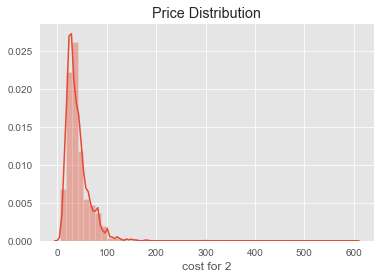

In [79]:
import seaborn as sns 
plt.style.use('ggplot')
sns.distplot(restaurants['cost for 2']).set_title('Price Distribution');

The distribution of prices seem slightly right skewed. This is more or less expected given the number of fine dining restaurants that tend to be significantly more expensive than median prices. Here is a list of restaurants in the right tail below: 

In [46]:
restaurants.loc[restaurants['cost for 2'] > 150]

,occasion,name,avg review,review count,neighborhood,address,cuisines,cost for 2,Lat,Lng,Google Addresses,Postal Codes
63,FINE DINING,360 Restaurant,4.1,346,"CN Tower, Entertainment District","CN Tower, 301 Front Street West, Toronto M5V 2T6","Canadian, Grill",180,43.642566,-79.387056,"CN Tower, 301 Front St W, Toronto, ON M5V 2T6,...",M5V
79,CASUAL DINING,Sushi Kaji,4.6,184,"The Queensway, Etobicoke","860 The Queensway, Etobicoke M8Z 1N7",Sushi,160,43.624944,-79.509953,"860 The Queensway, Etobicoke, ON M8Z 1N7, Canada",M8Z
88,FINE DINING,Barberian's Steakhouse And Tavern,4.4,276,Downtown Yonge,"7 Elm Street, Toronto M5G 1H1",Steak,160,43.657594,-79.382170,"7 Elm St, Toronto, ON M5G 1H1, Canada",M5G
94,FINE DINING,Harbour Sixty,4.3,270,"Bay Street, Harbourfront","60 Harbour Street, Toronto","Seafood, American",180,43.642101,-79.378453,"60 Harbour St, Toronto, ON M5J 1B7, Canada",M5J
99,FINE DINING,Yasu,4.3,75,"Harbord Street, Harbord Village","81 Harbord Street, Toronto M5S 1G4","Sushi, Japanese, Asian",160,43.662730,-79.403183,"81 Harbord St, Toronto, ON M5S 1G4, Canada",M5S
126,CASUAL DINING,Edulis,4.2,121,"Niagara Street, Niagara","169 Niagara Street, Toronto M5V 1C9",European,155,43.641948,-79.406579,"169 Niagara St, Toronto, ON M5V 1C9, Canada",M5V
144,FINE DINING,Zen,4.7,136,"Woodbine Avenue, Markham",7634 Woodbine Avenue. Markham L3R 2N2,"Sushi, Japanese, Asian",300,43.829078,-79.353684,"7634 Woodbine Ave, Markham, ON L3R 2N2, Canada",L3R
251,FINE DINING,La Castile,4.4,159,"Dundas Street East, Mississauga","2179 Dundas Street E, Mississauga L4X 1M3","Seafood, Grill",160,43.626338,-79.566710,"2179 Dundas St E, Mississauga, ON L4X 1M3, Canada",L4X
326,FINE DINING,Morton's - Park Hyatt Toronto Yorkville,4.1,119,"Bloor Street West, The Annex","Park Hyatt Toronto Yorkville, 4 Avenue Road, T...",Steak,180,43.669163,-79.394945,"4 Avenue Rd, Toronto, ON M5R 2E8, Canada",M5R
512,FINE DINING,Momofuku Shōtō,3.3,69,"University Avenue, Entertainment District","Momofuku, Third Floor, 190 University Avenue, ...","Japanese, Asian",180,43.649447,-79.386370,"190 University Ave, Toronto, ON M5H 0A3, Canada",M5H


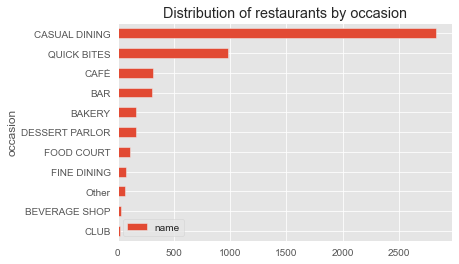

In [47]:
top_occasions = restaurants.groupby(by = ['occasion']).count()
top_occasions.sort_values(by = ['name'], ascending = False, inplace = True)

top_occasions1 = top_occasions.sort_values(by = ['name'], ascending = False)[:10]
other = [sum(top_occasions['name'][10:])] * len(top_occasions.columns)
top_occasions1.loc[len(top_occasions1)] = other

top_occasions1.rename(index = {10: 'Other'}, inplace = True)
top_occasions1.reset_index(inplace = True)
top_occasions1 = top_occasions1[['occasion', 'name']].sort_values(by = 'name')

plt.style.use('ggplot')
top_occasions1.plot(kind = 'barh', x = 'occasion', y = 'name')
plt.title('Distribution of restaurants by occasion')
plt.show()

No surprise here, casual dining establishments are the most common, followed by quick bites and cafes. Let's sort dinning occasions by average reviews so see if Toronto favours some occasions over others.

In [48]:
occasion_stats = restaurants.groupby(by = ['occasion']).mean()
occasion_stats.sort_values(by = ['avg review'], ascending = False)

,avg review,review count,cost for 2,Lat,Lng
occasion,,,,,
FINE DINING,3.897333,94.680000,125.866667,43.673233,-79.452621
SANDWICH SHOP,3.850000,61.000000,27.500000,43.655726,-79.397607
DESSERT PARLOR,3.656790,36.580247,18.851852,43.693520,-79.429368
CASUAL DINING,3.612526,50.937544,46.805575,43.705452,-79.434920
COFFEE SHOP,3.600000,21.000000,20.000000,43.646409,-79.389872
BREWERY,3.600000,4.000000,25.000000,43.658951,-79.350272
BAKERY,3.597619,25.785714,19.476190,43.717583,-79.422548
QUICK BITES,3.553659,28.528455,25.322154,43.691069,-79.457118
PUB,3.521739,19.260870,49.086957,43.985948,-81.173240


Let's take a quick and dirty look at the best reviewed cuisines. A more robust approach would be to test difference in means (t-test) but I'll save that for a follow-up study. For now, it's out of scope.

In [49]:
cuisines_stats = restaurants.groupby(by = ['cuisines']).mean()
cuisines_stats.sort_values(by = ['avg review'], ascending = False).head(10)

,avg review,review count,cost for 2,Lat,Lng
cuisines,,,,,
"Ice Cream, Asian",4.9,134.0,15.0,43.655983,-79.392686
"Desserts, Patisserie, Cafe",4.9,361.0,20.0,43.645927,-79.411439
"Sri Lankan, Healthy Food",4.9,238.0,35.0,43.647585,-79.392032
"Cantonese, Vegetarian, Chinese",4.6,95.0,25.0,43.651918,-79.403376
"Mediterranean, Middle Eastern, Sandwich",4.6,48.0,20.0,43.899420,-78.675994
"Hakka Chinese, Indian, Asian",4.5,101.0,40.0,43.568178,-79.665998
"Tapas, Asian Fusion",4.5,219.0,40.0,43.648654,-79.420288
"Asian Fusion, Asian",4.5,572.0,85.0,43.644159,-79.400445
"Spanish, Tapas, Bar Food",4.5,262.0,105.0,43.655245,-79.415366


Let's take a quick look at how reviews are distributed (both counts and ratings)

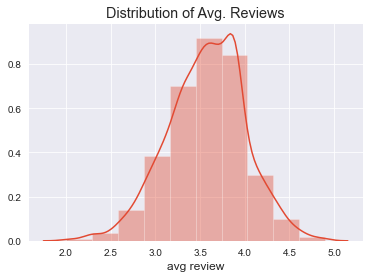

In [50]:
sns.set_style('darkgrid')
sns.distplot(restaurants['avg review'], bins = 10).set_title('Distribution of Avg. Reviews');

Unsurprisingly, the review distribution looks more or less gaussian (with reviews of 4 stars having a slightly higher share than expected). 

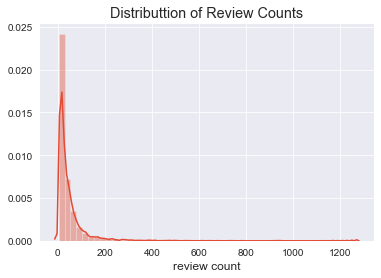

In [51]:
sns.distplot(restaurants['review count']).set_title('Distributtion of Review Counts');

Much like prices, the distribution of review counts are are also fairly right skewed; indicating that only a small subset of restaurants garner an impressive amount of reviews. Here are the top 25 most reviewed restaurants below: 

In [52]:
restaurants.sort_values(by = ['review count'], ascending = False).head(25)

,occasion,name,avg review,review count,neighborhood,address,cuisines,cost for 2,Lat,Lng,Google Addresses,Postal Codes
6,CASUAL DINING,Salad King,4.2,1262,"Yonge Street, Downtown Yonge","340 Yonge Street, Toronto M5B 1R8","Thai, Asian",30,43.657648,-79.381728,"340 Yonge St, Toronto, ON M5B 1R8, Canada",M5B
1,CASUAL DINING,KINKA IZAKAYA,4.6,1166,"Church Street, Church And Wellesley","398 Church Street, Toronto M5B 2A2 2A2","Japanese, Asian",55,43.660422,-79.378989,"398 Church St, Toronto, ON M5B 2A2, Canada",M5B
0,CASUAL DINING,Pizzeria Libretto,4.5,1010,"Ossington Avenue, Trinity Bellwoods","221 Ossington Avenue, Toronto M6J 2Z8","Pizza, Italian",50,43.649002,-79.420343,"221 Ossington Ave, Toronto, ON M6J 2Z8, Canada",M6J
12,CASUAL DINING,Terroni,4.1,948,"Queen Street West, Trinity Bellwoods","720 Queen Street W, Toronto M6J 1E8","Italian, Pizza",65,43.646306,-79.409167,"720 Queen St W, Toronto, ON M5V 2B5, Canada",M5V
3,QUICK BITES,Banh Mi Boys,4.7,941,"Queen Street West, Fashion District","392 Queen Street West, Toronto",Sandwich,25,43.648827,-79.396970,"392 Queen St W, Toronto, ON M5V 2A6, Canada",M5V
13,QUICK BITES,The Burger's Priest,4.2,780,"Queen Street East, The Beaches","1636, Queen St. E, Toronto",Burger,30,43.666829,-79.315642,"1636 Queen St E, Toronto, ON M4L 1G3, Canada",M4L
4,QUICK BITES,The Stockyards,4.6,734,"Saint Clair Avenue West, Forest Hill","699 St Clair Avenue West, Toronto M6C 1B2","BBQ, Burger",25,43.681346,-79.426147,"699 St Clair Ave W, Toronto, ON M6C 1B2, Canada",M6C
5,CASUAL DINING,Grand Electric,4.4,725,"Queen Street West, Brockton Village","1330 Queen Street West, Toronto",Mexican,40,43.641774,-79.431610,"1330 Queen St W, Toronto, ON M6K 1L4, Canada",M6K
23,CASUAL DINING,Grazie Ristorante,4.2,694,"Yonge Street, Yonge & Eglinton","2373 Yonge Street, Toronto M4P 2C8",Italian,60,43.709345,-79.398696,"2373 Yonge St, Toronto, ON M4P 2C8, Canada",M4P
9,FINE DINING,Canoe,4.5,676,"Wellington Street West, Financial District","66 Wellington St. W, TD Bank Tower, 54th Floor...","Canadian, Bar Food",150,43.647579,-79.380904,"66 Wellington St W 54th floor, Toronto, ON M5K...",M5K


If we consider review count to be a good proxy for a restaurant's popularity, it would be interesting to explore the kinds of features that make one restaurant more popular than another (i.e determine which variables -- if any -- are good predictors of a restaurant's review count). 

This would be, of course, a regression problem which we could later explore. 

### Most Common Cuisines

While Toronto is famous for its myriad of diverse cuisines, it would still be insteresting to see which are more common. I find that waffle-charts usually do the best job of visualising the distribution of categorical variables such as cuisine types. Since we've got over 200 different kinds of cuisines captured in our dataset, we'll just look at the top 10 and how they compare to the rest. 

To do this, we'll first need to get the count of restaurants for each cuisine. There are a number of ways we can do this but I'll simply take advantage of dummy variable dataframe (onehot) and sum up each column to obtain the count. Since dummies are =1 when "hot" and 0 otherwise, the sum of each column gives us the count of restaurants belonging to the column set. Similarly, the column mean gives us the proportion -- the beauty of dummies. 

After, we can simply throw these values into a new dataframe (which we'll call top_10_cuisines) and sort in descending order. We'll then discard all indexes >= 10 so that we're left with the top 10. 

Now, it might be interesting to see how the top 10 stack up against all other kinds of cuisines. Since each restaurant can be labelled more than a single kind of cuisine (eg. a restaurant could be labelled: Italian, Pizza, Desserts), we can't simply subtract the sum of the counts in our top 10 from the total count of restaurants (i.e the count of restaurants captured by the top 10 cuisines ranges from min(count_cuisine types) if all the restaurants belong to all labels and sum(count_cuisine types) if each belongs to just 1 label). 

Instead, we'll look at the set of restaurants with sets of cuisine labels completely disjoint from the set of labels in our top 10. In other words, restaurants with cuisines that are not top 10 cuisines. This can be achieved by creating cuisine label sets for each restaurant and checking if the intersection of that set with the set of top 10 cuisine labels is empty. 

Once we have a set of all the other restaurants (i.e non-top 10 cuisine restaurants), we can add the count and proportion to our top_10_cuisines dataframe as 'Other'. 

Now, we can generate a waffle-chart illustrating the frequency of major cuisine types in Toronto.

In [86]:
# force our labels into a cleaner format
def clean_labels(s):
    return s[s.find("_") + 1:]

top_10_cuisines = pd.DataFrame({'count': list(onehot.sum(axis = 0))}, index = list(map(lambda x: clean_labels(x), onehot.columns)))
top_10_cuisines['percentage'] = (top_10_cuisines['count']/len(onehot) * 100).round(2)
top_10_cuisines = top_10_cuisines.sort_values(by = ['count'], ascending = False)[:10]

top_10_cuisines

,count,percentage
Asian,794,15.56
Bar Food,410,8.03
Italian,349,6.84
Cafe,311,6.09
Chinese,287,5.62
Sushi,285,5.58
Japanese,285,5.58
Indian,216,4.23
Chinese,202,3.96
Pizza,200,3.92


In [87]:
top = list(top_10_cuisines.index)
top = set(map(lambda x: clean_labels(x), top))

others = restaurants.loc[list(len(set(x for x in str(y).strip(" ").split(",")).intersection(top)) == 0 for y in restaurants['cuisines'])]
top_10_cuisines.loc[len(top_10_cuisines)] = [len(others), round(len(others)/len(onehot)*100, 2)]
top_10_cuisines.rename(index = {10: 'Other'}, inplace = True)


top_10_cuisines

,count,percentage
Asian,794.0,15.56
Bar Food,410.0,8.03
Italian,349.0,6.84
Cafe,311.0,6.09
Chinese,287.0,5.62
Sushi,285.0,5.58
Japanese,285.0,5.58
Indian,216.0,4.23
Chinese,202.0,3.96
Pizza,200.0,3.92


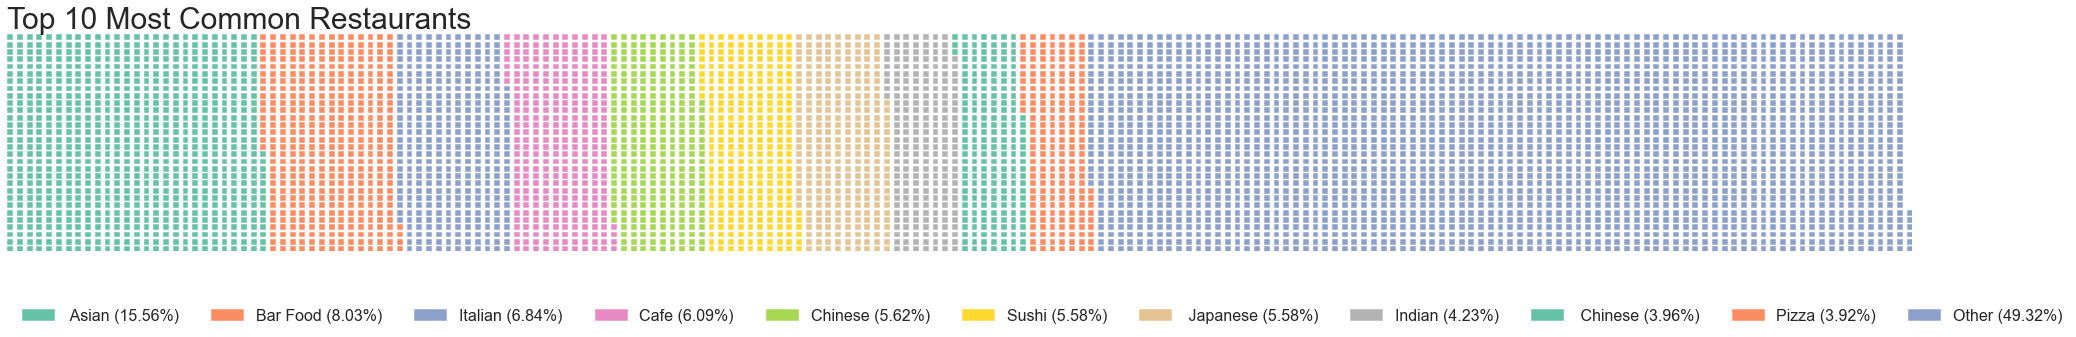

In [93]:
from pywaffle import Waffle

fig = plt.figure(FigureClass = Waffle, 
                rows = 30, 
                values = top_10_cuisines['count'], 
                labels = [f'{clean_labels(x)} ({y}%)' for x, y in zip(top_10_cuisines.index, top_10_cuisines['percentage'])], 
                figsize = (30,15),
                interval_ratio_x=1,
                interval_ratio_y=0.5,
                legend = {
                    'loc': 'lower left',
                    'bbox_to_anchor': (0, -0.4),
                    'ncol': len(top_10_cuisines['count']),
                    'framealpha': 0,
                    'fontsize': 16
                }, 
                title = {
                    'label': 'Top 10 Most Common Restaurants', 
                    'loc': 'left', 
                    'fontdict': {
                        'fontsize': 30
                    }
                    
                })
plt.savefig('restaurants_waffle.png')

## Wordcloud

While our waffle-chart paints a good image of the most common cuisines, I find that wordclouds sometimes provide a useful additional perspective. Besides, they make for a good opportunity to have a little more fun with our visualisations.

In [56]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

print('Done!')

Done!


In [57]:
def text_consolidator(text): 
    consol = list()
    for x in text: 
        for y in str(x).strip(" ").split(","): 
            consol.append(y)
    return consol

text = "".join(cuisine + " " for cuisine in text_consolidator(restaurants['cuisines']))
    
# text = " ".join(str(cuisine) for cuisine in restaurants['cuisines'])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 77148 words in the combination of all review.


In [58]:
toronto_mask = np.array(Image.open('Toronto_silhouette.jpg'))
toronto_mask

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 59,  59,  59],
        [ 59,  59,  59],
        [ 59,  59,  59],
        ...,
        [ 59,  59,  59],
        [ 59,  59,  59],
        [ 59,  59,  59]]

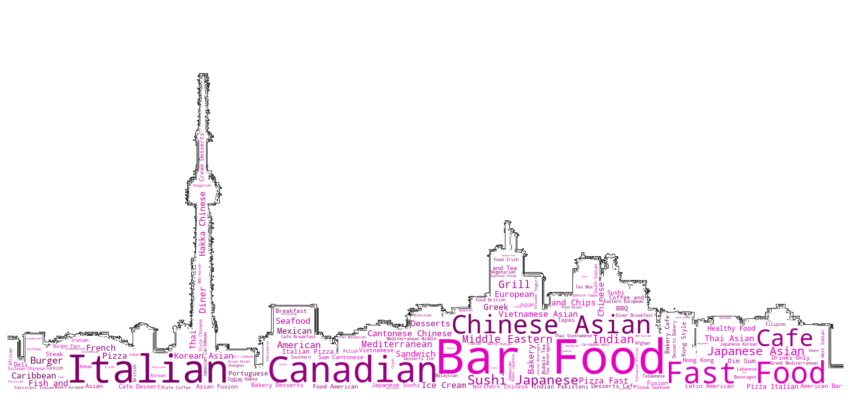

In [59]:
# Customize colours
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(310)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", mask = toronto_mask, max_words = 1000, contour_width = 0.2, 
                     color_func = random_color_func).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file('restaurants_word_cloud.png')

## Some Relationships

While in depth analysis of the relationships between restaurant features is outside the scope of this project (for now anyway), it doesn't hurt to plot our data too see if our quantitative variables (review count, avg review, cost for 2) are correlated in any way. Personally, I'd like to know if more expensive restaurants tend to be better rated and if better restaurants tend to garner a greater number of reviews. We can explore these relationships by generating some scatterplots. I want to stress that these plots don't lend themselves well to any robust conclusions, but should instead give us an idea of how our restaurant features are related.

Down the line, it would be interesting to see what makes a restaurant more attractive than another by looking at the variables driving average reviews. This, of course, would be a regression problem which we could explore in a follow-up 

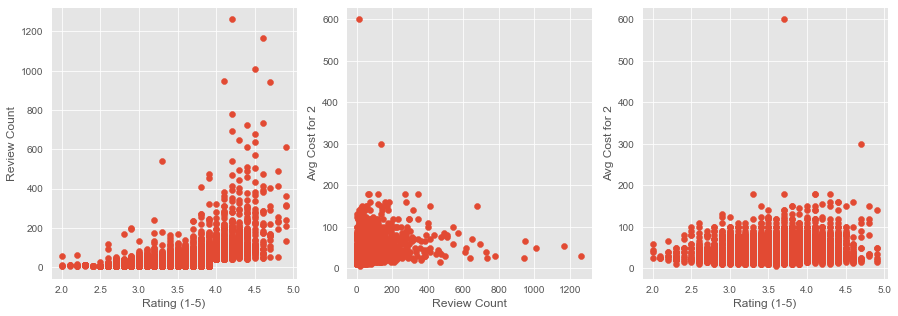

In [60]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.scatter(restaurants['avg review'], restaurants['review count'])
ax1.set(xlabel = 'Rating (1-5)', ylabel = 'Review Count');
ax2.scatter(restaurants['review count'], restaurants['cost for 2'])
ax2.set(xlabel = 'Review Count', ylabel = 'Avg Cost for 2');
ax3. scatter(restaurants['avg review'], restaurants['cost for 2'])
ax3.set(xlabel = 'Rating (1-5)', ylabel = 'Avg Cost for 2');

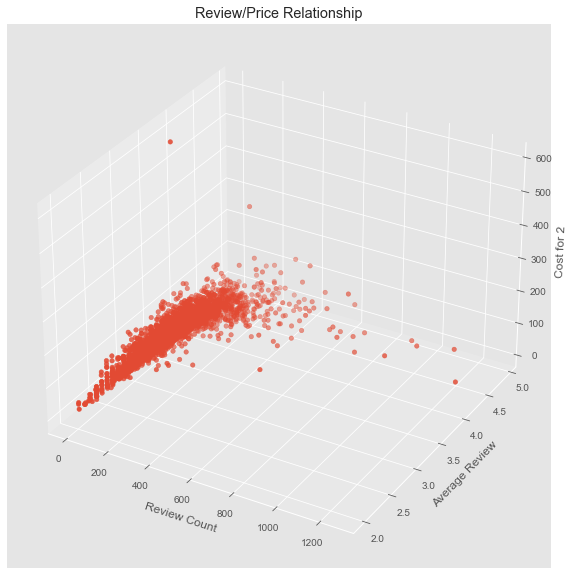

In [61]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax1 = plt.axes(projection='3d')
ax1.scatter(restaurants['review count'], restaurants['avg review'], restaurants['cost for 2'])
ax1.set_title('Review/Price Relationship')

ax1.set_xlabel('Review Count')
ax1.set_zlabel('Cost for 2')
ax1.set_ylabel('Average Review');

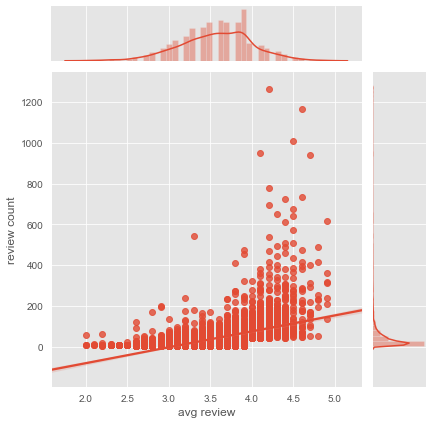

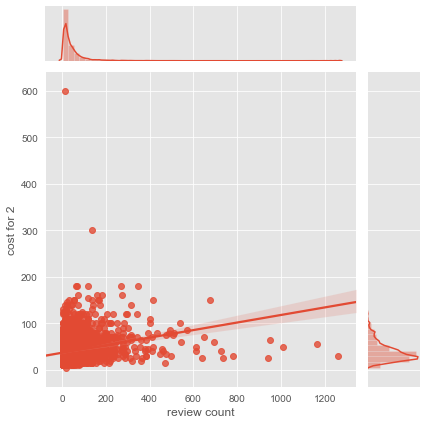

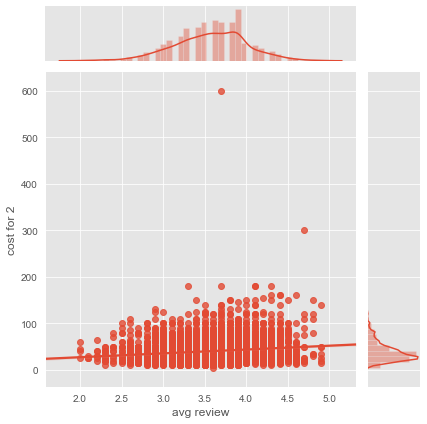

In [62]:
ax1 = sns.jointplot('avg review', 'review count', data = restaurants, kind = 'reg')
ax2 = sns.jointplot('review count', 'cost for 2', data = restaurants, kind = 'reg')
ax3 = sns.jointplot('avg review', 'cost for 2', data = restaurants, kind = 'reg')

#### Correlation Matrix: 

It would also be illustrative to plot the relationships between our numeric variables (above) in a correlation matrix heatmap. We'll that below: 

In [63]:
matrix = restaurants[['review count', 'avg review', 'cost for 2']]
corrMatrix = matrix.corr()
print (corrMatrix)

              review count  avg review  cost for 2
review count      1.000000    0.486183    0.237638
avg review        0.486183    1.000000    0.150103
cost for 2        0.237638    0.150103    1.000000


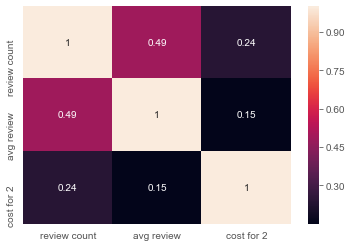

In [64]:
corrMatrix = matrix.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

From our plots, it looks like cost and review counts are somewhat positively correlated though it's hard to know if this generalizes beyond our data given the heterogeneity of variance in our errors (i.e our review counts aren't very evenly distributed and so it's likely that a specific group of restaurants is disproportionately driving the relationship). We can also see that better rated restaurants tend to (on average) garner a greater number of reviews. The relationship could be the reverse, of course, but it seems more intuitive that good restaurants get more reviews than the converse (though a quick glance at our correlation matrix reveals there might not be much of a relationship at all). 

## Clustering Restaurants

Alright, now for the meat of the matter -- clustering. As stated earlier, our ultimate goal is to segment the Toronto restaurant market into distinct groups. To do this, we'll appeal to k-means but first we'll have to transform our data so that it can be handled by our learning algorithm. To reiterate, most of our data is categorical and presently coded as dummies (which follow a binomial distribution). Since k-means aims to minimize the euclidian distance between datapoints and cluster centroids (while maximizing euclidian distance between cluster centroids), it generally performs poorly on categorical data. The k-modes algorithm is better equiped for this, but conversely does not handle continuous data very well. To work around these constraints, we can reduce our data into its principle components. This should yield more continuous data across board (though it does sacrifice some information). Given the sparseness of many of our dummies, we should intuitively be able to reduce our data quite a bit without sacrificing too much explained variance, which we will then be able to pass directly to our k-means algorithm. 

In [65]:
X = restaurants[['avg review', 'review count', 'cost for 2']].join(onehot)
print(X.shape)
print('# datapoints: {}'.format(X.shape[0] * X.shape[1]))
X.head()

(5084, 235)
# datapoints: 1194740


,avg review,review count,cost for 2,d_,d_,d_ Afghan,d_ African,d_ American,d_ Argentine,d_ Asian,...,d_Tibetan,d_Trinbagonian,d_Turkish,d_Ukrainian,d_Vegetarian,d_Venezuelan,d_Vietnamese,d_West Indian,d_Xinjiang,d_Yunnan
0,4.5,1010,50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.6,1166,55,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4.9,614,50,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4.7,941,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.6,734,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### PCA:

Let's start by reducing our data's dimensionality by running a Principle Component Analysis on it. We'll plot the cummulative explained variance on the number components to decide by how much to reduce our data. We'll select n-components explaining 95% of the total variance in our data (this is a little more art than science). 

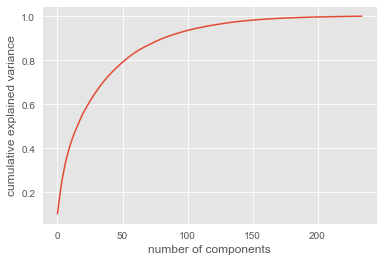

In [66]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

X = np.array(X)

# Normalize features
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

# Run PCA 
transformer = PCA()
transformer.fit(X_scaled)

# Plot explained variance ratio on n_components
plt.style.use('ggplot')
plt.plot(np.cumsum(transformer.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Looks like roughly 100 components explain 95% of our data so we'll reduce it to that.

In [67]:
transformed = PCA(n_components = 100)
X = transformed.fit_transform(X_scaled)

print(transformed.explained_variance_ratio_)

[0.10293346 0.04700702 0.04638311 0.0396066  0.03514456 0.03059222
 0.03007791 0.02451683 0.02349642 0.02025436 0.01978592 0.0176312
 0.01680133 0.01512    0.01440936 0.01392302 0.01379477 0.01352818
 0.01336243 0.01291627 0.01148734 0.01079207 0.01047182 0.01026768
 0.01016911 0.00990213 0.00969781 0.00941943 0.00934286 0.00888878
 0.00856793 0.00837208 0.00817659 0.00804492 0.00775554 0.00760995
 0.00721426 0.00696158 0.00682654 0.00667894 0.00656587 0.00620919
 0.00596735 0.00592028 0.00576568 0.00570013 0.00568193 0.00540692
 0.00532527 0.00527947 0.00520479 0.00506788 0.00498052 0.00493893
 0.00486879 0.0046112  0.00457121 0.00428356 0.00426046 0.00407247
 0.0040298  0.00396512 0.00365366 0.00345289 0.00338939 0.00334103
 0.0032636  0.00314103 0.00302247 0.00299081 0.00293134 0.00290311
 0.00289273 0.00283172 0.00277024 0.00273364 0.00272027 0.00270707
 0.00267998 0.00266157 0.00246164 0.00237591 0.00235872 0.00225305
 0.00223591 0.00201437 0.00200032 0.00196412 0.00192565 0.00191

In [68]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.224094,0.009093,-0.198850,-0.186240,0.691984,0.022080,0.629819,0.040812,0.120844,-0.122832,...,-0.006207,-0.014886,-0.014713,-0.058147,0.096312,0.027829,-0.101980,-0.063450,0.106617,-0.026315
1,0.694220,-0.316574,0.083666,0.081363,-0.014002,-0.180344,0.075156,0.038857,-0.080268,-0.430889,...,-0.014737,-0.049643,-0.028955,-0.068477,0.090442,0.022733,-0.109928,-0.073281,0.119704,-0.005799
2,0.726860,-0.355698,0.096108,0.088915,-0.025793,-0.217460,0.103845,0.057794,-0.068956,-0.560515,...,-0.007835,-0.033797,-0.000581,-0.022319,0.050849,0.007020,-0.053821,-0.042575,0.052880,-0.016444
3,-0.147839,0.021414,-0.087354,-0.001083,0.050378,-0.042540,-0.073518,-0.038698,-0.047038,-0.033638,...,-0.057777,-0.013599,-0.041211,-0.015613,0.070274,0.012762,-0.112560,-0.065893,0.076030,-0.052242
4,-0.156828,0.032162,-0.037604,-0.002142,0.057659,-0.047928,-0.078241,-0.046474,-0.089010,-0.037502,...,-0.005467,0.008010,-0.015304,-0.039846,0.077606,0.009253,-0.113928,-0.026677,0.063480,-0.039673


#### Picking Hyperparameters (n_clusters):

Now our data is ready to be passed to our learning algorithm. K-means requires us to set a hyperparameter n_clusters (the number of clusters to which we'll be assigning datapoints). This process tends to be a little more art than science but it helps to plot the square errors against the number of clusters. Note that squared errors will generally decrease as the number of clusters increases so we can't really minimize it without also overfitting our data. Instead, we'll look for an inflection point (elbow method) where the rate of change more or less levels off. 

 30

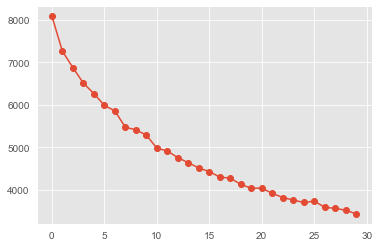

In [69]:
from sklearn.cluster import KMeans

cost = []
for n in np.arange(1, 31): 
    print('\r {}'.format(n), end="")
    
    kmeans = KMeans(n_clusters = n, random_state = 0)
    kmeans.fit(X)
    
    cost.append(kmeans.inertia_)
    
plt.plot(cost, '-o');

Seams like our model only fits marginally better beyond 15 clusters, so we'll pick that to be our n_clusters hyperparameter.

In [70]:
kmeans = KMeans(n_clusters = 15, random_state = 0)
kmeans.fit(X)

print(kmeans.cluster_centers_)
print(kmeans.labels_)

[[-1.79034699e-01 -1.64764313e-02 -1.08626895e-01 ... -3.26331195e-03
  -1.58669610e-04  1.91977717e-03]
 [-2.48242167e-01  9.16838385e-03 -3.68990944e-01 ... -5.11258086e-04
  -5.41676283e-04 -2.74527583e-04]
 [ 7.49648044e-01 -4.60945428e-01  1.68046193e-01 ...  6.31816343e-04
  -5.03476021e-04 -4.88666772e-04]
 ...
 [-1.31898074e-01 -4.56667659e-03 -7.12743917e-02 ... -2.68355676e-03
  -1.46710988e-03 -1.89484908e-04]
 [ 6.21082300e-01 -4.64658223e-01  1.54378210e-01 ...  3.55776873e-04
  -1.08012548e-03 -1.76817028e-03]
 [-1.80964148e-01  1.09030572e-03 -5.26749564e-02 ... -5.31331755e-04
   3.39965300e-04  6.19447210e-04]]
[5 2 2 ... 8 6 6]


Now that our restaurants have been clustered, let's add the cluster labels to our restaurants dataframe.

In [71]:
restaurants['Cluster'] = kmeans.labels_
restaurants.head()

,occasion,name,avg review,review count,neighborhood,address,cuisines,cost for 2,Lat,Lng,Google Addresses,Postal Codes,Cluster
0,CASUAL DINING,Pizzeria Libretto,4.5,1010,"Ossington Avenue, Trinity Bellwoods","221 Ossington Avenue, Toronto M6J 2Z8","Pizza, Italian",50,43.649002,-79.420343,"221 Ossington Ave, Toronto, ON M6J 2Z8, Canada",M6J,5
1,CASUAL DINING,KINKA IZAKAYA,4.6,1166,"Church Street, Church And Wellesley","398 Church Street, Toronto M5B 2A2 2A2","Japanese, Asian",55,43.660422,-79.378989,"398 Church St, Toronto, ON M5B 2A2, Canada",M5B,2
2,CASUAL DINING,Pai,4.9,614,"Duncan Street, Entertainment District","18 Duncan Street, Toronto","Thai, Asian",50,43.647869,-79.388685,"18 Duncan St, Toronto, ON M5H 3G8, Canada",M5H,2
3,QUICK BITES,Banh Mi Boys,4.7,941,"Queen Street West, Fashion District","392 Queen Street West, Toronto",Sandwich,25,43.648827,-79.396970,"392 Queen St W, Toronto, ON M5V 2A6, Canada",M5V,8
4,QUICK BITES,The Stockyards,4.6,734,"Saint Clair Avenue West, Forest Hill","699 St Clair Avenue West, Toronto M6C 1B2","BBQ, Burger",25,43.681346,-79.426147,"699 St Clair Ave W, Toronto, ON M6C 1B2, Canada",M6C,8


In [72]:
restaurants.to_csv('restaurants_data_map.csv')

## Cluster Analysis

Now that we've segmented the Toronto restaurant market, let's see what defines each of our clusters. We might be interested in seeing the average price points, or the most common kinds of restaurants in each cluster, so let's do that here.

In [73]:
onehot = pd.read_csv('one_hot_restaurants.csv', index_col = ['Unnamed: 0'])
clusters = restaurants.join(onehot)

In [74]:
clusters = clusters.groupby('Cluster').mean()
clusters.head()

,avg review,review count,cost for 2,Lat,Lng,d_,d_,d_ Afghan,d_ African,d_ American,...,d_Tibetan,d_Trinbagonian,d_Turkish,d_Ukrainian,d_Vegetarian,d_Venezuelan,d_Vietnamese,d_West Indian,d_Xinjiang,d_Yunnan
Cluster,,,,,,,,,,,,,,,,,,,,,
0,3.614103,27.102564,18.852564,43.699929,-79.435123,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,3.702890,55.653179,59.942197,43.701685,-79.464990,0.0,0.000000,0.0,0.0,0.005780,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,3.543981,44.284722,35.888889,43.699634,-79.463569,0.0,0.002315,0.0,0.0,0.002315,...,0.002315,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0
3,3.501739,26.860870,24.208696,43.689025,-79.411572,0.0,0.000000,0.0,0.0,0.017391,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,3.676132,53.403292,47.135802,43.696844,-79.437496,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [75]:
# get most common features

def mostCommonFeatures(row, num_top_features): 
    row_feature = row.iloc[4:]
    row_feature_sorted = row_feature.sort_values(ascending = False)
    
    return row_feature_sorted.index.values[0:num_top_features]

num_top_features = 5
indicators = ['st', 'nd', 'rd']
columns = ['Cluster']

for ind in np.arange(num_top_features): 
    try: 
        columns.append('{}{} Most Common Feature'.format(ind + 1, indicators[ind]))
    except: 
        columns.append('{}th Most Common Feature'.format(ind + 1))
# new df 
new_df = pd.DataFrame(columns = columns)
new_df['Cluster'] = clusters.index

In [76]:
for ind in np.arange(clusters.shape[0]):
    new_df.iloc[ind ,1:] = mostCommonFeatures(clusters.iloc[ind, :], num_top_features)
    
new_df = new_df.set_index('Cluster')

for column in new_df.columns: 
    new_df[column] = new_df[column].apply(clean_labels) # earlier function for cleaning cuisines

In [77]:
cluster_features = clusters.iloc[:, :3].join(new_df)
cluster_features

,avg review,review count,cost for 2,1st Most Common Feature,2nd Most Common Feature,3rd Most Common Feature,4th Most Common Feature,5th Most Common Feature
Cluster,,,,,,,,
0,3.614103,27.102564,18.852564,Bakery,Cafe,Desserts,Chinese,Italian
1,3.702890,55.653179,59.942197,Italian,Pizza,Sandwich,Mediterranean,European
2,3.543981,44.284722,35.888889,Asian,Chinese,Thai,Vietnamese,Korean
3,3.501739,26.860870,24.208696,Fast Food,Burger,Middle Eastern,Italian,Pizza
4,3.676132,53.403292,47.135802,Japanese,Sushi,Asian,Korean,Thai
5,3.625500,40.595000,33.115000,Pizza,Fast Food,Italian,Sandwich,Middle Eastern
6,3.509355,26.874194,24.335484,Cafe,Desserts,Bakery,Breakfast,Coffee and Tea
7,3.442927,34.648780,52.651220,Bar Food,American,Canadian,British,Grill
8,3.581970,41.480980,39.156331,Chinese,Middle Eastern,Diner,Mediterranean,Caribbean


Finally, our restaurants are clustered (into 15 market segments) and we have each cluster's main features above. A quick look shows that our model did a decent job of clustering restaurants into more or less consistent groups, though it would certainly improve with better data. 

In [78]:
cluster_features.to_csv('cluster_features.csv')